# Projectile Motion

This section will look at solving the projectile motion of a baseball. Without air resistance, the problem can be solved with elementary physics. With air resistance, however, we must resort to numerical methods. 

The equation of motion for the baseball is:

$$ \frac{dv}{dt} = \frac{1}{m}F_a(v) - g\hat y $$

The force of air resistance is a function of the velocity. The last term is the gravitational acceleration multiplied by the unit vector in the y-direction. The force from air resistance is often approximated as:

$$ F_a = -\frac{1}{2}C_d\rho A |v|v $$

The drag coefficient of a baseball is dependent on its Reynolds number. Its drag coefficient is also typically lower than that of a smooth sphere because the stitching disrupts laminar flow around the ball, precipitating the onset of turbulence. At low Reynolds numbers, the drag coefficient is dependent on the Re itself. At higher Re, vortex shedding maintains a nearly constant drag coefficient of about 0.5. At the critical Re (approximately $3x10^{5}$ for a smooth sphere), turbulent flow disrupts the low pressure region in the wake behind the sphere.

A baseball's mass and diameter are 0.145 kg and 7.4 cm.

## Forward Derivative

Performing the numerical analysis requires computation of the derivative. The derivative is defined as:

$$ f'(x) = \lim_{\tau \to 0} \frac{f(t + \tau) - f(t)}{\tau} $$

A special version of a Taylor expansion can be used where:

$$ f(t + \tau) = f(t) + \tau f'(t) + \frac{\tau^2}{2}f''(\zeta) $$

Where $\zeta$ is a value between $t$ and $t + \tau$. The above expression can be rewritten as:

$$ f'(t) = \frac{f(t + \tau) - f(t)}{\tau} - \frac{1}{2}\tau f''(\zeta) $$

The last term is the truncation error. If the term is kept, the expression for $f'(t)$ is exact. But, we can't compute that term, because we don't know what $\zeta$ is. But, we can bound the error, because we know the limits: $\zeta$ is somewhere between $t$ and $t + \tau$.

## Euler's Method

The equations of motion to be solved, generally, are:

$$\frac{dv}{dt} = a(r, v); \frac{dr}{dt} = v $$

In projectile motion, the acceleration is only a function of $v$ because of air resistance. In later sections, such as the motions of comets, acceleration will also be a function of position.

Using the forward derivative, the equations of motion are:

$$ \frac{v(t + \tau) - v(t)}{\tau} + O(\tau) = a(r(t), v(t)) $$

$$ \frac{r(t + \tau) - r(t)}{\tau} + O(\tau) = v(t) $$

Which, when rearranged, evaluate to:

$$ v(t + \tau) = v(t) + \tau a(r(t), v(t)) + O(\tau^2) $$

$$ r(t + \tau) = r(t) + \tau v(t) + O(\tau^2) $$

How is Euler's method implemented in practice? First, a change in notation. $f_n = f(t_n); t_n = n\tau; n = 0, 1, ...$, so $f_0 = f(t=0)$. Dropping the error term from above, our updates become:

$$v_{n+1} = v_n + \tau a_n$$

$$r_{n+1} = r_n + \tau v_n$$

The calculation of the trajectory proceeds as follows:

1. Specify the initial conditions, $r_0$ and $v_0$. 
2. Choose a time step $\tau$.
3. Calculate the acceleration given the current r and v.
4. Use the previous two equations to update r and v.
5. Proceed back to step 3 and continue until the desired number of trajectory points have been calculated.

An alternative to the Euler method is the _Euler-Cromer_ method, which uses the updated velocity to update the position. This changes the second equation to be:

$$r_{n+1} = r_n + \tau v_{n+1}$$

Additionally, the _midpoint method_ also changes the position equation. For the midpoint method, the second equation becomes:

$$r_{n+1} = r_n + \tau \frac{v_{n+1} + v_n}{2}$$

which is obviously an average of the second term of the Euler and Euler-Cromer methods. Inserting the equation for velocity into the midpoint method returns the familiar projectile equation:

$$ r_{n+1} = r_n + \tau v_n + \frac{1}{2}a_n \tau^2 $$

By making some comparisons to equations in the book, we can see that the error is on the order of $\tau^2 a$. If the acceleration were $10 m/s^2$, then the single-step truncation error would be $10^{-1} m$ for $\tau = 10^{-1} s$.

For implementing trajectory analysis using the Euler method:

1. Set initial position $r_0$ and initial velocity $v_0$.
2. Set the physical parameters ($m, C_d$, etc.)
3. Loop until the ball hits the ground or maximum steps are completed
    - Record position for plotting
    - Compute acceleration
    - Calaulate the new position and velocity
    - If the ball reaches the ground (y < 0), break the loop
4. Print max range and time of flight
5. Graph the trajectory

In [3]:
import numpy as np

In [4]:
def balle():
    ''' Function to compute the trajectory of a baseball using the Euler method'''
    ''' The drag coefficient is calculated using quadratic interpolation based on information
    given for Cd vs speeds between 0 and 55.9 m/s (125 mph). Therefore, speeds above 125 mph
    will lead to inaccurate results.
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    
    ## Set initial position and velocity of the baseball
    y0 = float(input('Enter initial height (meters): '))
    r0 = np.array([0, y0]) # initial position vector
    speed = float(input('Enter initial speed (m/s): '))
    theta = float(input('Enter initial angle (degrees): '))
    v0 = np.array([speed * np.cos(theta*np.pi/180), 
                  speed * np.sin(theta*np.pi/180)]) # vector components of speed
    r = np.copy(r0)
    v = np.copy(v0)
    
    ## Set physical parameters
    #Cd = 0.35          # drag coefficient
    area = 4.3e-3      # cross-sectional area (m^2)
    grav = 9.81        # gravitational acceleration (m/s^2)
    mass = .145       # mass of projectile (kg)
    airFlag = int(input('Air resistance? (Yes: 1, No: 0)'))
    if airFlag:
        rho = 1.2      # density of air (kg/m^3)
    else:
        rho = 0
    
    ## Loop until ball hits the ground or max steps completed
    tau = float(input('Enter time step (sec): '))    # time step (sec)
    maxstep = 1000      # max number of time steps
    xplot = np.empty(maxstep)
    yplot = np.empty(maxstep)
    xNoAir = np.empty(maxstep)
    yNoAir = np.empty(maxstep)
    
    for istep in range(maxstep):
        # Interpolate Cd based on speed
        speed = np.linalg.norm(v)
        if speed <= 22.4:
            Cd = 0.5
        elif speed > 22.4 and speed <= 44.7:
            v_interp = np.array([22.4, 33.5, 44.7])
            Cd_interp = np.array([0.5, 0.4, 0.28])
            Cd = interp_Cd(v_interp, Cd_interp, speed)
        else:
            v_interp = np.array([33.5, 44.7, 55.9])
            Cd_interp = np.array([0.4, 0.28, 0.23])
            Cd = interp_Cd(v_interp, Cd_interp, speed)
            
        
        air_const = -0.5 * Cd * rho * area / mass  # air resistance constant based on Cd
            
        xplot[istep] = r[0]    # record trajectory for each plot
        yplot[istep] = r[1]
        t = istep * tau        # current time
        xNoAir[istep] = r0[0] + v0[0] * t
        yNoAir[istep] = r0[1] + v0[1] * t - 0.5 * grav * t**2
        
        # calculate acceleration
        accel = air_const * np.linalg.norm(v) * v   # air resistance
        accel[1] -= grav                            # gravity
        
        # Calculate new position and velocity using Euler method
        r = r + tau * v          # Euler step
        v = v + tau * accel
        
        # If ball reaches ground (y < 0), break out of loop
        if r[1] < 0:
            laststep = istep + 1
            xplot[laststep] = r[0]   # record last values
            yplot[laststep] = r[1]
            break
    
    # Interpolate to find true (corrected) range based on where the last point closest to the 
    # ground, i.e. the last positive y value
    x, y, interp_range = interp(xplot[laststep-3:laststep+1], yplot[laststep-3:laststep+1])
    
    # Print max range and time of flight
    print(f'Corrected range is {interp_range[0]:.2f} meters')
    print(f'Simple range is {r[0]:.2f} meters')
    print(f'Time of flight is {laststep*tau:.1f} seconds')
    
    ## Graph the trajectory
    # Mark the location of the ground by a straight line
    xground = np.array([0., xNoAir[laststep-1]])
    yground = np.array([0., 0.])
    
    # plot the computed trajectory with no air
    plt.plot(xplot[0:laststep+1], yplot[0:laststep+1], '+', label='Euler Method')
    plt.plot(xNoAir[0:laststep], yNoAir[0:laststep], '-', label='Theory (no air)')
    plt.plot(xground, yground, 'r-')
    #plt.plot(x, y, 'b--', label='Interpolation')
    plt.legend()
    plt.xlabel('Range (m)')
    plt.ylabel('Height (m)')
    plt.title('Projectile motion')
    plt.show()

Enter initial height (meters):  1
Enter initial speed (m/s):  50
Enter initial angle (degrees):  45
Air resistance? (Yes: 1, No: 0) 1
Enter time step (sec):  0.1


Corrected range is 120.50 meters
Simple range is 121.06 meters
Time of flight is 6.0 seconds


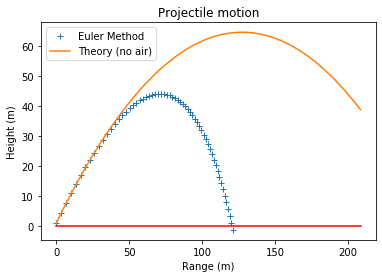

In [10]:
balle()

We now want to make a correction to the program. The _balle_ function will overestimate the range, since it chooses the final iteration as the range, which is at y < 0. Instead, we will modify the linear interpolation function from the previous chapter, and have it return the x value where y = 0.

In [6]:
def interp(x, y):
    ''' Function to perform quadratic interpolation on a set of 3 data points'''
    import matplotlib.pyplot as plt
    xmin = x[0]
    xmax = x[-1]
    
    xi = np.linspace(xmin, xmax, 100)
    
    yi = ((xi - x[1])*(xi - x[2]))/((x[0] - x[1])*(x[0] - x[2])) * y[0] + \
         ((xi - x[0])*(xi - x[2]))/((x[1] - x[0])*(x[1] - x[2])) * y[1] + \
         ((xi - x[0])*(xi - x[1]))/((x[2] - x[0])*(x[2] - x[1])) * y[2]
    
#     plt.plot(x, y, '*', label='Given points')
#     plt.plot(xi, yi, '--', label='interpolation')
#     plt.legend()

    y_ = yi[yi > 0]
    ymin = min(y_)
    
    return x, y, xi[yi==ymin]

In [7]:
def interp_Cd(x, y, target):
    ''' Function to perform quadratic interpolation on a set of 3 data points'''
    
    xmin = x[0]
    xmax = x[-1]
    
    xi = np.linspace(xmin, xmax, 100)
    
    yi = ((xi - x[1])*(xi - x[2]))/((x[0] - x[1])*(x[0] - x[2])) * y[0] + \
         ((xi - x[0])*(xi - x[2]))/((x[1] - x[0])*(x[1] - x[2])) * y[1] + \
         ((xi - x[0])*(xi - x[1]))/((x[2] - x[0])*(x[2] - x[1])) * y[2]
    
    return yi[abs(xi - target).argmin()]

In [8]:
x = np.array([1, 2, 3])
y = np.array([9, 7, 3])

In [9]:
ans = interp(x, y)

The balle function above was ultimately update to include a dynamic drag coefficient, and to interpolate the last three position updates to find the range that represents the closest point that the ball gets to the ground without actually having a negative y value. Using the final point overestimates the range, which you see in the corrected vs simple ranges that are printed out.

Below is an implementation of the Euler-Cromer update step instead of the Euler step. The only difference is reversing the order that the position and velocity get updated in. In Euler-Cromer, the velocity is updated first, and then the position is updated using the updated velocity. For the same initial conditions (1m height, 50 m/s speed, 45 degree angle, 0.1 sec time interval), the Euler-Cromer results were about 5 meters shorter than the Euler results. 

In [11]:
def balle_EulerCromer():
    import numpy as np
    import matplotlib.pyplot as plt
    
    ## Set initial position and velocity of the baseball
    y0 = float(input('Enter initial height (meters): '))
    r0 = np.array([0, y0]) # initial position vector
    speed = float(input('Enter initial speed (m/s): '))
    theta = float(input('Enter initial angle (degrees): '))
    v0 = np.array([speed * np.cos(theta*np.pi/180), 
                  speed * np.sin(theta*np.pi/180)]) # vector components of speed
    r = np.copy(r0)
    v = np.copy(v0)
    
    ## Set physical parameters
    #Cd = 0.35          # drag coefficient
    area = 4.3e-3      # cross-sectional area (m^2)
    grav = 9.81        # gravitational acceleration (m/s^2)
    mass = .145       # mass of projectile (kg)
    airFlag = int(input('Air resistance? (Yes: 1, No: 0)'))
    if airFlag:
        rho = 1.2      # density of air (kg/m^3)
    else:
        rho = 0
    
    ## Loop until ball hits the ground or max steps completed
    tau = float(input('Enter time step (sec): '))    # time step (sec)
    maxstep = 1000      # max number of time steps
    xplot = np.empty(maxstep)
    yplot = np.empty(maxstep)
    xNoAir = np.empty(maxstep)
    yNoAir = np.empty(maxstep)
    
    for istep in range(maxstep):
        # Interpolate Cd based on speed
        speed = np.linalg.norm(v)
        if speed <= 22.4:
            Cd = 0.5
        elif speed > 22.4 and speed <= 44.7:
            v_interp = np.array([22.4, 33.5, 44.7])
            Cd_interp = np.array([0.5, 0.4, 0.28])
            Cd = interp_Cd(v_interp, Cd_interp, speed)
        else:
            v_interp = np.array([33.5, 44.7, 55.9])
            Cd_interp = np.array([0.4, 0.28, 0.23])
            Cd = interp_Cd(v_interp, Cd_interp, speed)
            
        
        air_const = -0.5 * Cd * rho * area / mass  # air resistance constant based on Cd
            
        xplot[istep] = r[0]    # record trajectory for each plot
        yplot[istep] = r[1]
        t = istep * tau        # current time
        xNoAir[istep] = r0[0] + v0[0] * t
        yNoAir[istep] = r0[1] + v0[1] * t - 0.5 * grav * t**2
        
        # calculate acceleration
        accel = air_const * np.linalg.norm(v) * v   # air resistance
        accel[1] -= grav                            # gravity
        
        # Calculate new position and velocity using Euler method
        v = v + tau * accel
        r = r + tau * v      # Euler-Cromer step
        # If ball reaches ground (y < 0), break out of loop
        if r[1] < 0:
            laststep = istep + 1
            xplot[laststep] = r[0]   # record last values
            yplot[laststep] = r[1]
            break
        
        # Interpolate to find true (corrected) range based on where the last point closest to the 
    # ground, i.e. the last positive y value
    x, y, interp_range = interp(xplot[laststep-3:laststep+1], yplot[laststep-3:laststep+1])
    
    # Print max range and time of flight
    print(f'Corrected range is {interp_range[0]:.2f} meters')
    print(f'Simple range is {r[0]:.2f} meters')
    print(f'Time of flight is {laststep*tau:.1f} seconds')
    
    ## Graph the trajectory
    # Mark the location of the ground by a straight line
    xground = np.array([0., xNoAir[laststep-1]])
    yground = np.array([0., 0.])
    
    # plot the computed trajectory with no air
    plt.plot(xplot[0:laststep+1], yplot[0:laststep+1], '+', label='Euler-Cromer Method')
    plt.plot(xNoAir[0:laststep], yNoAir[0:laststep], '-', label='Theory (no air)')
    plt.plot(xground, yground, 'r-')
    #plt.plot(x, y, 'b--', label='Interpolation')
    plt.legend()
    plt.xlabel('Range (m)')
    plt.ylabel('Height (m)')
    plt.title('Projectile motion')
    plt.show()

Enter initial height (meters):  1
Enter initial speed (m/s):  50
Enter initial angle (degrees):  45
Air resistance? (Yes: 1, No: 0) 1
Enter time step (sec):  0.1


Corrected range is 115.33 meters
Simple range is 115.37 meters
Time of flight is 5.7 seconds


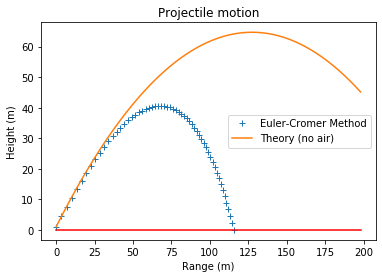

In [12]:
balle_EulerCromer()

In [15]:
def balle_midpoint():
    import numpy as np
    import matplotlib.pyplot as plt
    
    ## Set initial position and velocity of the baseball
    y0 = float(input('Enter initial height (meters): '))
    r0 = np.array([0, y0]) # initial position vector
    speed = float(input('Enter initial speed (m/s): '))
    theta = float(input('Enter initial angle (degrees): '))
    v0 = np.array([speed * np.cos(theta*np.pi/180), 
                  speed * np.sin(theta*np.pi/180)]) # vector components of speed
    r = np.copy(r0)
    v = np.copy(v0)
    
    ## Set physical parameters
    #Cd = 0.35          # drag coefficient
    area = 4.3e-3      # cross-sectional area (m^2)
    grav = 9.81        # gravitational acceleration (m/s^2)
    mass = .145       # mass of projectile (kg)
    airFlag = int(input('Air resistance? (Yes: 1, No: 0)'))
    if airFlag:
        rho = 1.2      # density of air (kg/m^3)
    else:
        rho = 0
    
    ## Loop until ball hits the ground or max steps completed
    tau = float(input('Enter time step (sec): '))    # time step (sec)
    maxstep = 1000      # max number of time steps
    xplot = np.empty(maxstep)
    yplot = np.empty(maxstep)
    xNoAir = np.empty(maxstep)
    yNoAir = np.empty(maxstep)
    
    for istep in range(maxstep):
        # Interpolate Cd based on speed
        speed = np.linalg.norm(v)
        if speed <= 22.4:
            Cd = 0.5
        elif speed > 22.4 and speed <= 44.7:
            v_interp = np.array([22.4, 33.5, 44.7])
            Cd_interp = np.array([0.5, 0.4, 0.28])
            Cd = interp_Cd(v_interp, Cd_interp, speed)
        else:
            v_interp = np.array([33.5, 44.7, 55.9])
            Cd_interp = np.array([0.4, 0.28, 0.23])
            Cd = interp_Cd(v_interp, Cd_interp, speed)
            
        
        air_const = -0.5 * Cd * rho * area / mass  # air resistance constant based on Cd
            
        xplot[istep] = r[0]    # record trajectory for each plot
        yplot[istep] = r[1]
        t = istep * tau        # current time
        xNoAir[istep] = r0[0] + v0[0] * t
        yNoAir[istep] = r0[1] + v0[1] * t - 0.5 * grav * t**2
        
        # calculate acceleration
        accel = air_const * np.linalg.norm(v) * v   # air resistance
        accel[1] -= grav                            # gravity
        
        # Calculate new position and velocity using Euler method
        v_n = v.copy()
        v = v + tau * accel
        r = r + tau * (v + v_n)/2      # midpoint step
        # If ball reaches ground (y < 0), break out of loop
        if r[1] < 0:
            laststep = istep + 1
            xplot[laststep] = r[0]   # record last values
            yplot[laststep] = r[1]
            break
        
        # Interpolate to find true (corrected) range based on where the last point closest to the 
    # ground, i.e. the last positive y value
    x, y, interp_range = interp(xplot[laststep-3:laststep+1], yplot[laststep-3:laststep+1])
    
    # Print max range and time of flight
    print(f'Corrected range is {interp_range[0]:.2f} meters')
    print(f'Simple range is {r[0]:.2f} meters')
    print(f'Time of flight is {laststep*tau:.1f} seconds')
    
    ## Graph the trajectory
    # Mark the location of the ground by a straight line
    xground = np.array([0., xNoAir[laststep-1]])
    yground = np.array([0., 0.])
    
    # plot the computed trajectory with no air
    plt.plot(xplot[0:laststep+1], yplot[0:laststep+1], '+', label='Midpoint Method')
    plt.plot(xNoAir[0:laststep], yNoAir[0:laststep], '-', label='Theory (no air)')
    plt.plot(xground, yground, 'r-')
    #plt.plot(x, y, 'b--', label='Interpolation')
    plt.legend()
    plt.xlabel('Range (m)')
    plt.ylabel('Height (m)')
    plt.title('Projectile motion')
    plt.show()

Enter initial height (meters):  1
Enter initial speed (m/s):  50
Enter initial angle (degrees):  45
Air resistance? (Yes: 1, No: 0) 1
Enter time step (sec):  0.1


Corrected range is 117.92 meters
Simple range is 118.76 meters
Time of flight is 5.9 seconds


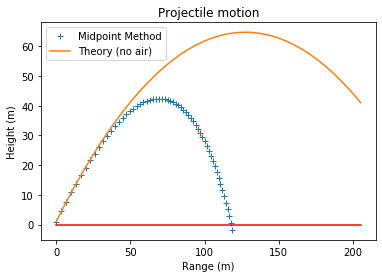

In [16]:
balle_midpoint()

# Simple Pendulum

The equation of motion for a pendulum can be derived from the equation for torque, which is equal to the moment of inertia multiplied by the angular acceleration:

$$ \tau = I\alpha $$

The torque is given by the length of the pendulum $L$ multiplied by the component of force perpenducular to the pendulum arm. For gravitational forces only, that component is $mgsin\theta$. Therefore, the equation of motion for a simple pendulum is:

$$ \frac{d^2\theta}{dt^2} = -\frac{g}{L}sin\theta $$

Recall that a centered difference is given by:

$$ f'(t) = \frac{f(t + \tau) - f(t - \tau)}{2\tau} + O(\tau^2) $$ 

The centered difference has error on the order of $\tau^2$, which is better than the forward or backward differences. The second centered derivative is the centered derivative of the centered derivative, which gives:

$$ f''(t) = \frac{f(t + \tau) + f(t - \tau) - 2f(t)}{\tau^2} + O(\tau^2) $$

The pendulum problem seeks to find $\theta$ and $\omega$, but we will still use the notation $v$ and $r$. The equations of motion are:

$$ \frac{dv}{dt} = a(r(t)) $$

$$ \frac{dr}{dt} = v(t) $$

The acceleration depends only on position, which is evident from the equations of motion derived above. Discretizing the velocity derivative using the centered difference:

$$ \frac{v(t + \tau) - v(t - \tau)}{2\tau} + O(\tau^2) = a(r(t)) $$

Note that to evaluate the acceleration at time $t$, we use the velocity at time $t + \tau$ and $t - \tau$. The position will be discretized between time $t + 2\tau$ and $t$:

$$ \frac{r(t + 2\tau) - r(t)}{2\tau} + O(\tau^2) = v(t + \tau) $$

Using the prior notation, the discretizations become:

$$ \frac{v_{n+1} - v_{n-1}}{2\tau} + O(\tau^2) = a(r_n) $$

$$ \frac{r_{n+2} - r_n}{2\tau} + O(\tau^2) = v_{n+1} $$

Rearranging terms give the update steps:

$$ v_{n+1} = v_{n-1} + 2\tau a(r_n) + O(\tau^3) $$

$$ r_{n+2} = r_n + 2\tau v_{n+1} + O(\tau^3) $$

The above method is called the _leap frog method_. The solution is advanced in steps of $2\tau$, with the position evaluated at even steps ($r_0, r_2, r_4$) and the velocity evaluated at odd steps ($v_1, v_2, v_3$).

An alternative is to use the _Verlet method_. Beginning with different equations of motion:

$$ \frac{dr}{dt} = v(t) $$

$$ \frac{d^2r}{dt^2} = a(r) $$

The central difference equations for first and second derivatives give:

$$ \frac{r_{n+1} - r_{n-1}}{2\tau} + O(\tau^2) = v_n $$

$$ \frac{r_{n+1} + r_{n-1} - 2r_n}{\tau^2} + O(\tau^2) = a_n $$

Rarranging the second term:

$$ r_{n+1} = 2r_n - r_{n-1} + \tau^2a_n + O(\tau^4) $$

The leap-frog and Verlet methods are not "self-starting." We need the initial conditions, $r_0, v_0$, but also the position and velocity at $t = -\tau$, $r_{-1}, v_{-1}$. There are methods for getting the Verlet method started, such as taking a backward step:

$$ r_{-1} = r_0 - \tau v_0 + \frac{\tau^2}{2}a(r_0) $$

## Pendulum Program

The equations for the simple pendulum are:

$$ \frac{d\omega}{dt} = \alpha(\theta) $$

$$ \frac{d\theta}{dt} = \omega $$

where the angular acceleration is $\alpha(\theta) = -(g/L)sin\theta $. The Euler method for solving this system is:

$$ \theta_{n+1} = \theta_n + \tau \omega_n $$

$$ \omega_{n+1} = \omega_n + \tau \alpha_n $$

If we are only interested in the angle and not the velocity, the Verlet method can be used to give:

$$ \theta_{n+1} = 2\theta_n - \theta_{n-1} + \tau^2\alpha_n $$

The program will estimate the period by checking if the angle has changed sign. After the first reversal, each sign change will estimate the period by:

$$ T_k = 2\tau(n_{k+1} - n_k) $$

where $n_k$ is the time step on which the $kth$ reversal occurred.

The implementation of the program will be:

1. Select the numerical method to use: Euler of Verlet
2. Set initial position $\theta_0$ and velocity $\omega_0 = 0$
3. Set physical constants and other variables
4. Take on backward step to start Verlet
5. Loop over desired number of steps with given time step and numerical method:
    - Record angle and time for plotting
    - Compute new position and velocity using Euler or Verlet
    - Test if the pendulum has passed through $\theta = 0$. If yes, use time to estimate period
6. Estimate period of oscillation, including error bar
7. Graph the oscillations

The period is recorded for each angle reversal, and an average period is computed. The error bar for the measured period is estimated as $\sigma = s/\sqrt{M}$, where

$$ s = \sqrt{\frac{1}{N-1}\sum^N_{k=1}(T_k - T_{avg})^2} $$

which is the sample standard deviation of T.

In [21]:
def pendul():
    ''' Program to compute the motion of a simple pendulum using Euler or Verlet method'''
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Select either Euler or Verlet
    numericalMethod = int(input('Choose a numerical method (1: Euler, 2: Verlet): '))
    
    # Set initial position and velocity
    theta0 = float(input('Enter initial angle (degrees): '))
    theta = theta0 * np.pi/180       # Convert angle to radians
    omega = 0.0
    
    # Set the physical constants and other variables
    g_over_L = 1.0           # The constant g/L
    time = 0.0               # Initial time
    irev = 0                 # Count for angle reversals
    tau = float(input('Enter the time step: '))
    
    # Take one backward step to start Verlet
    accel = -g_over_L * np.sin(theta)
    theta_old = theta - tau * omega + (tau**2 / 2.) * accel
    
    # Loop over desired number of steps with the given time step and method
    nstep = int(input('Enter the desired number of time steps: '))
    t_plot = np.empty(nstep)
    th_plot = np.empty(nstep)
    period = np.empty(nstep)   # Used to record period estimates
    
    for istep in range(nstep):
        
        # Record angle and time for plotting
        t_plot[istep] = time
        th_plot[istep] = theta * 180 / np.pi    # Convert angle to degrees
        time += tau
        
        # Compute new position and velocity
        accel = -g_over_L * np.sin(theta)
        if numericalMethod == 1:
            theta_old = theta       # Save previous angle
            theta += tau * omega    # Euler step
            omega += tau * accel
        else:
            theta_new = 2 * theta - theta_old + tau**2 * accel
            theta_old = theta       # Verlet method
            theta = theta_new
            
        # Test if pendulum has passed through theta = 0
        # If yes, use time to estimate period
        if theta * theta_old < 0:   # Test position for sign change
            print(f'Turning point at time t = {time}')
            if irev == 0:           # If this is the first sign change
                time_old = time
            else:
                period[irev-1] = 2 * (time - time_old)
                time_old = time
            irev += 1               # Increment number of reversals
            
    # Estimate period of oscillation, including error bar
    nPeriod = irev - 1              # Number of times period was measured
    avgPeriod = np.mean(period[0:nPeriod])
    errorBar = np.std(period[0:nPeriod]) / np.sqrt(nPeriod)
    print(f'Average period = {avgPeriod:.2f} +/- {errorBar:.2f}')
        
    # Graph the oscillations as theta vs time
    plt.plot(t_plot, th_plot, '+')
    plt.xlabel('Time')
    plt.ylabel(r'$\theta$(degrees)')
    plt.show()

Choose a numerical method (1: Euler, 2: Verlet):  1
Enter initial angle (degrees):  10
Enter the time step:  0.1
Enter the desired number of time steps:  300


Turning point at time t = 1.6000000000000003
Turning point at time t = 4.799999999999999
Turning point at time t = 7.999999999999988
Turning point at time t = 11.099999999999977
Turning point at time t = 14.299999999999965
Turning point at time t = 17.49999999999998
Turning point at time t = 20.700000000000024
Turning point at time t = 23.90000000000007
Turning point at time t = 27.100000000000115
Average period = 6.38 +/- 0.02


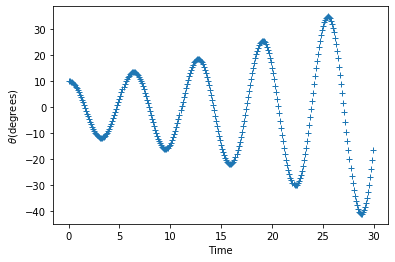

In [22]:
pendul()

The ratio g/L is taken to be unity for this program, which causes the small amplitude period to be approximately $2\pi$. The estimated period, given by equation 2.38 in the book, should be $2\pi (1.002) = 6.3$ sec. The computed period is about 1.5% larger. Additionally, the Euler method errors begin compounding, and the pendulum oscillations begin to grow in amplitude. If we reduce the time step and increase the number of steps, we may improve the results:

Choose a numerical method (1: Euler, 2: Verlet):  1
Enter initial angle (degrees):  10
Enter the time step:  0.05
Enter the desired number of time steps:  600


Turning point at time t = 1.6000000000000008
Turning point at time t = 4.749999999999991
Turning point at time t = 7.89999999999998
Turning point at time t = 11.050000000000022
Turning point at time t = 14.200000000000067
Turning point at time t = 17.35000000000011
Turning point at time t = 20.550000000000157
Turning point at time t = 23.700000000000202
Turning point at time t = 26.850000000000247
Average period = 6.31 +/- 0.01


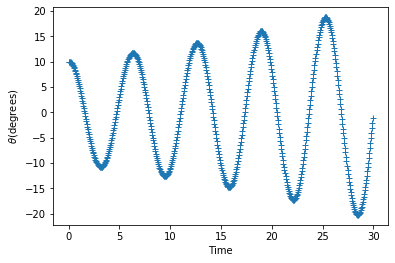

In [23]:
pendul()

The period measurement has certainly improved, but the oscillations are still growing in amplitude using the Euler method. Switching to the Verlet method:

Choose a numerical method (1: Euler, 2: Verlet):  2
Enter initial angle (degrees):  10
Enter the time step:  0.1
Enter the desired number of time steps:  300


Turning point at time t = 1.6000000000000003
Turning point at time t = 4.799999999999999
Turning point at time t = 7.899999999999988
Turning point at time t = 11.099999999999977
Turning point at time t = 14.199999999999966
Turning point at time t = 17.399999999999977
Turning point at time t = 20.50000000000002
Turning point at time t = 23.600000000000065
Turning point at time t = 26.80000000000011
Turning point at time t = 29.900000000000155
Average period = 6.29 +/- 0.03


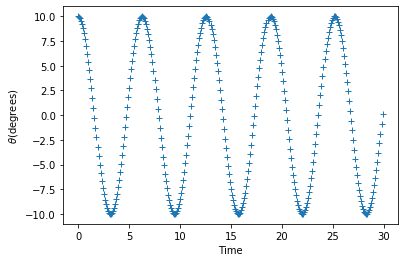

In [24]:
pendul()

This method is much more stable. The oscillations do not appear to be growing, and the initial period estimate is good. Now, let's use a large initial angle, $\theta = 90$. The period estimation from eq 2.38 is 7.252 seconds.

Choose a numerical method (1: Euler, 2: Verlet):  2
Enter initial angle (degrees):  90
Enter the time step:  0.1
Enter the desired number of time steps:  300


Turning point at time t = 1.9000000000000006
Turning point at time t = 5.599999999999996
Turning point at time t = 9.299999999999983
Turning point at time t = 12.99999999999997
Turning point at time t = 16.699999999999967
Turning point at time t = 20.40000000000002
Turning point at time t = 24.100000000000072
Turning point at time t = 27.900000000000126
Average period = 7.43 +/- 0.03


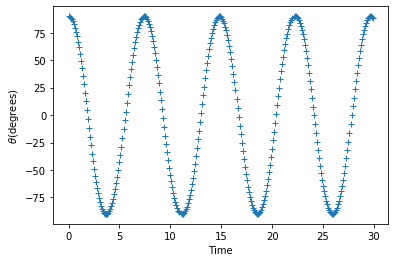

In [26]:
pendul()

This period estimation is still good, even with this large initial angle. Using a very large initial angle of 170 degrees, the period estimated from 2.38 should be 9.74 seconds.

Choose a numerical method (1: Euler, 2: Verlet):  2
Enter initial angle (degrees):  170
Enter the time step:  0.1
Enter the desired number of time steps:  300


Turning point at time t = 3.900000000000002
Turning point at time t = 11.499999999999975
Turning point at time t = 19.200000000000003
Turning point at time t = 26.900000000000112
Average period = 15.33 +/- 0.05


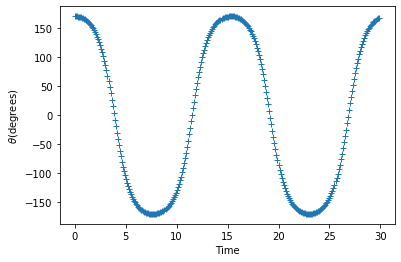

In [27]:
pendul()

The approximation for the period from equation 2.37 breaks down at this large angle. 